# My Ferrite.jl Manual  

## Import Packages

In [1]:
using SparseArrays
using Ferrite
using Plots 

## Section 1: Introduction 

<b>Goal</b>: To provide a manual for Ferrite.jl to be used in the EE4375 course.  

## Section 2: Mesh Generation for a Rectangle in 1D

In [46]:
# generate 1D grid for testing purposes 
nels  = (10,)        # number of elements in each spatial direction
left  = Vec((0.,))   # start point for geometry: lower-left point of the square 
right = Vec((1.,))   # end point for geometry: upper-right point of the square
#grid = generate_grid(Line, nels,left, right) 
grid = generate_grid(Line,nels,left,right)

Grid{1, Line, Float64} with 10 Line cells and 11 nodes

In [47]:
for cell in grid.cells display(cell) end 

Line((1, 2))

Line((2, 3))

Line((3, 4))

Line((4, 5))

Line((5, 6))

Line((6, 7))

Line((7, 8))

Line((8, 9))

Line((9, 10))

Line((10, 11))

## Section 3: Mesh Generation for a Rectangle in 2D

Here we explore the mesh generator that Ferrite provides. 

In [2]:
?generate_grid

search: generate_grid



```
generate_grid(celltype::Cell, nel::NTuple, [left::Vec, right::Vec)
```

Return a `Grid` for a rectangle in 1, 2 or 3 dimensions. `celltype` defined the type of cells, e.g. `Triangle` or `Hexahedron`. `nel` is a tuple of the number of elements in each direction. `left` and `right` are optional endpoints of the domain. Defaults to -1 and 1 in all directions.


In [18]:
# use "methods(generate_grid)" to see alternative grid types  
methods(generate_grid)

# 26 methods for generic function "generate_grid":
[1] generate_grid(::Type{QuadraticLine}, nel::Tuple{Int64}) in Ferrite at /Users/djplahaye/.julia/packages/Ferrite/5Ozov/src/Grid/grid_generators.jl:57
[2] generate_grid(::Type{QuadraticLine}, nel::Tuple{Int64}, left::Vec{1, T}) where T in Ferrite at /Users/djplahaye/.julia/packages/Ferrite/5Ozov/src/Grid/grid_generators.jl:57
[3] generate_grid(::Type{QuadraticLine}, nel::Tuple{Int64}, left::Vec{1, T}, right::Vec{1, T}) where T in Ferrite at /Users/djplahaye/.julia/packages/Ferrite/5Ozov/src/Grid/grid_generators.jl:57
[4] generate_grid(::Type{Triangle}, nel::Tuple{Int64, Int64}, LL::Vec{2, T}, LR::Vec{2, T}, UR::Vec{2, T}, UL::Vec{2, T}) where T in Ferrite at /Users/djplahaye/.julia/packages/Ferrite/5Ozov/src/Grid/grid_generators.jl:350
[5] generate_grid(::Type{Wedge}, nel::Tuple{Int64, Int64, Int64}) in Ferrite at /Users/djplahaye/.julia/packages/Ferrite/5Ozov/src/Grid/grid_generators.jl:243
[6] generate_grid(::Type{Wedge}, nel::Tuple{Int64, Int64, Int64}, left::Vec{3, T}) where T in Ferrite at /Users/djplahaye/.julia/packages/Ferrite/5Ozov/src/Grid/grid_generators.jl:243
[7] generate_grid(::Type{Wedge}, nel::Tuple{Int64, Int64, Int64}, left::Vec{3, T}, right::Vec{3, T}) where T in Ferrite at /Users/djplahaye/.julia/packages/Ferrite/5Ozov/src/Grid/grid_generators.jl:243
[8] generate_grid(::Type{Tetrahedron}, cells_per_dim::Tuple{Int64, Int64, Int64}) in Ferrite at /Users/djplahaye/.julia/packages/Ferrite/5Ozov/src/Grid/grid_generators.jl:428
[9] generate_grid(::Type{Tetrahedron}, cells_per_dim::Tuple{Int64, Int64, Int64}, left::Vec{3, T}) where T in Ferrite at /Users/djplahaye/.julia/packages/Ferrite/5Ozov/src/Grid/grid_generators.jl:428
[10] generate_grid(::Type{Tetrahedron}, cells_per_dim::Tuple{Int64, Int64, Int64}, left::Vec{3, T}, right::Vec{3, T}) where T in Ferrite at /Users/djplahaye/.julia/packages/Ferrite/5Ozov/src/Grid/grid_generators.jl:428
[11] generate_grid(::Type{QuadraticTriangle}, nel::Tuple{Int64, Int64}, LL::Vec{2, T}, LR::Vec{2, T}, UR::Vec{2, T}, UL::Vec{2, T}) where T in Ferrite at /Users/djplahaye/.julia/packages/Ferrite/5Ozov/src/Grid/grid_generators.jl:388
[12] generate_grid(::Type{Line}, nel::Tuple{Int64}) in Ferrite at /Users/djplahaye/.julia/packages/Ferrite/5Ozov/src/Grid/grid_generators.jl:25
[13] generate_grid(::Type{Line}, nel::Tuple{Int64}, left::Vec{1, T}) where T in Ferrite at /Users/djplahaye/.julia/packages/Ferrite/5Ozov/src/Grid/grid_generators.jl:25
[14] generate_grid(::Type{Line}, nel::Tuple{Int64}, left::Vec{1, T}, right::Vec{1, T}) where T in Ferrite at /Users/djplahaye/.julia/packages/Ferrite/5Ozov/src/Grid/grid_generators.jl:25
[15] generate_grid(::Type{Cell{3, 20, 6}}, nel::Tuple{Int64, Int64, Int64}) in Ferrite at /Users/djplahaye/.julia/packages/Ferrite/5Ozov/src/Grid/grid_generators.jl:291
[16] generate_grid(::Type{Cell{3, 20, 6}}, nel::Tuple{Int64, Int64, Int64}, left::Vec{3, T}) where T in Ferrite at /Users/djplahaye/.julia/packages/Ferrite/5Ozov/src/Grid/grid_generators.jl:291
[17] generate_grid(::Type{Cell{3, 20, 6}}, nel::Tuple{Int64, Int64, Int64}, left::Vec{3, T}, right::Vec{3, T}) where T in Ferrite at /Users/djplahaye/.julia/packages/Ferrite/5Ozov/src/Grid/grid_generators.jl:291
[18] generate_grid(::Type{QuadraticQuadrilateral}, nel::Tuple{Int64, Int64}, LL::Vec{2, T}, LR::Vec{2, T}, UR::Vec{2, T}, UL::Vec{2, T}) where T in Ferrite at /Users/djplahaye/.julia/packages/Ferrite/5Ozov/src/Grid/grid_generators.jl:157
[19] generate_grid(C::Type{Quadrilateral}, nel::Tuple{Int64, Int64}, LL::Vec{2, T}, LR::Vec{2, T}, UR::Vec{2, T}, UL::Vec{2, T}) where T in Ferrite at /Users/djplahaye/.julia/packages/Ferrite/5Ozov/src/Grid/grid_generators.jl:120
[20] generate_grid(C::Type{Cell{2, M, N}}, nel::Tuple{Int64, Int64}) where {M, N} in Ferrite at /Users/djplahaye/.julia/packages/Ferrite/5Ozov/src/Grid/grid_generators.jl:111
[21] generate_grid(C::Type{Cell{2, M, N}}, nel::Tuple{Int64, Int64}, X::Array{Vec{2, T}, 1}) where {M, N, T} in 

Grid{1, Line, Float64} with 2 Line cells and 3 nodes

In [133]:
# generate coarse 2D grid for testing purposes 
nels  = (2, 2)            # number of elements in each spatial direction
left  = Vec((0.0, 0.0))   # start point for geometry: lower-left point of the square 
right = Vec((1.0, 1.0,))  # end point for geometry: upper-right point of the square
# grid = generate_grid(Quadrilateral, nels,left, right) 
grid = generate_grid(QuadraticQuadrilateral, nels,left, right) 

Grid{2, QuadraticQuadrilateral, Float64} with 4 QuadraticQuadrilateral cells and 25 nodes

### Loop over elements in the mesh 

In [134]:
#dump(grid.nodes)

In [135]:
for cell in grid.cells display(cell) end 

QuadraticQuadrilateral((1, 3, 13, 11, 2, 8, 12, 6, 7))

QuadraticQuadrilateral((3, 5, 15, 13, 4, 10, 14, 8, 9))

QuadraticQuadrilateral((11, 13, 23, 21, 12, 18, 22, 16, 17))

QuadraticQuadrilateral((13, 15, 25, 23, 14, 20, 24, 18, 19))

In [136]:
for node in grid.nodes display(node) end

Node{2, Float64}([0.0, 0.0])

Node{2, Float64}([0.25, 0.0])

Node{2, Float64}([0.5, 0.0])

Node{2, Float64}([0.75, 0.0])

Node{2, Float64}([1.0, 0.0])

Node{2, Float64}([0.0, 0.25])

Node{2, Float64}([0.25, 0.25])

Node{2, Float64}([0.5, 0.25])

Node{2, Float64}([0.75, 0.25])

Node{2, Float64}([1.0, 0.25])

Node{2, Float64}([0.0, 0.5])

Node{2, Float64}([0.25, 0.5])

Node{2, Float64}([0.5, 0.5])

Node{2, Float64}([0.75, 0.5])

Node{2, Float64}([1.0, 0.5])

Node{2, Float64}([0.0, 0.75])

Node{2, Float64}([0.25, 0.75])

Node{2, Float64}([0.5, 0.75])

Node{2, Float64}([0.75, 0.75])

Node{2, Float64}([1.0, 0.75])

Node{2, Float64}([0.0, 1.0])

Node{2, Float64}([0.25, 1.0])

Node{2, Float64}([0.5, 1.0])

Node{2, Float64}([0.75, 1.0])

Node{2, Float64}([1.0, 1.0])

### Evaluate a function over the mesh 

In [137]:
# what is a single node 
node = grid.nodes[1]
dump(node)

Node{2, Float64}
  x: Vec{2, Float64}
    data: Tuple{Float64, Float64}
      1: Float64 0.0
      2: Float64 0.0


In [138]:
myf(node) = node.x[1]+node.x[2]
myf.(grid.nodes)

25-element Vector{Float64}:
 0.0
 0.25
 0.5
 0.75
 1.0
 0.25
 0.5
 0.75
 1.0
 1.25
 0.5
 0.75
 1.0
 1.25
 1.5
 0.75
 1.0
 1.25
 1.5
 1.75
 1.0
 1.25
 1.5
 1.75
 2.0

## Section 4: Initializing cellvalues 

Requires documenting further the values stores on <i>cellvalues</i>.

In [6]:
?RefCube

search: RefCube



No documentation found.

# Summary

```
struct RefCube
```

# Supertype Hierarchy

```
RefCube <: Ferrite.AbstractRefShape <: Any
```


In [17]:
?QuadratureRule

search: QuadratureRule QuadraticQuadrilateral



```
QuadratureRule{dim,shape}([quad_rule_type::Symbol], order::Int)
```

Create a `QuadratureRule` used for integration. `dim` is the space dimension, `shape` an [`AbstractRefShape`](@ref) and `order` the order of the quadrature rule. `quad_rule_type` is an optional argument determining the type of quadrature rule, currently the `:legendre` and `:lobatto` rules are implemented.

A `QuadratureRule` is used to approximate an integral on a domain by a weighted sum of function values at specific points:

$\int\limits_\Omega f(\mathbf{x}) \text{d} \Omega \approx \sum\limits_{q = 1}^{n_q} f(\mathbf{x}_q) w_q$

The quadrature rule consists of $n_q$ points in space $\mathbf{x}_q$ with corresponding weights $w_q$.

In `Ferrite`, the `QuadratureRule` type is mostly used as one of the components to create a [`CellValues`](@ref) or [`FaceValues`](@ref) object.

**Common methods:**

  * [`getpoints`](@ref) : the points of the quadrature rule
  * [`getweights`](@ref) : the weights of the quadrature rule

**Example:**

```jldoctest
julia> QuadratureRule{2, RefTetrahedron}(1)
Ferrite.QuadratureRule{2,Ferrite.RefTetrahedron,Float64}([0.5], Tensors.Tensor{1,2,Float64,2}[[0.333333, 0.333333]])

julia> QuadratureRule{1, RefCube}(:lobatto, 2)
Ferrite.QuadratureRule{1,Ferrite.RefCube,Float64}([1.0, 1.0], Tensors.Tensor{1,1,Float64,1}[[-1.0], [1.0]])
```


In [139]:
# this part can be done independent of the mesh, correct? 
dim = 2
ip = Lagrange{dim, RefCube, 1}()
qr = QuadratureRule{dim, RefCube}(3)
cellvalues = CellScalarValues(qr, ip)

CellScalarValues{2, Float64, RefCube} with 4 shape functions and 9 quadrature points

In [140]:
#dump(cellvalues)

In [141]:
#cellvalues.N

## Section 5: Initialize DOF Handler and Loop over Elements 

Requires extension to describe the constraint handler. 

In [13]:
dh = DofHandler(grid)
add!(dh, :u, 1)
close!(dh);

In [14]:
dh

DofHandler
  Fields:
    :u, interpolation: Lagrange{2, RefCube, 1}(), dim: 1
  Dofs per cell: 4
  Total dofs: 9

In [15]:
# loop over elements and retrieve coordinate of the nodes of each cell 
for cell in CellIterator(dh)
    coords = getcoordinates(cell)
    display(coords)
end

4-element Vector{Vec{2, Float64}}:
 [0.0, 0.0]
 [0.5, 0.0]
 [0.5, 0.5]
 [0.0, 0.5]

4-element Vector{Vec{2, Float64}}:
 [0.5, 0.0]
 [1.0, 0.0]
 [1.0, 0.5]
 [0.5, 0.5]

4-element Vector{Vec{2, Float64}}:
 [0.0, 0.5]
 [0.5, 0.5]
 [0.5, 1.0]
 [0.0, 1.0]

4-element Vector{Vec{2, Float64}}:
 [0.5, 0.5]
 [1.0, 0.5]
 [1.0, 1.0]
 [0.5, 1.0]

In [16]:
# loop over quadrature points in all cells 
for (cellcount, cell) in enumerate(CellIterator(dh))
    coords = getcoordinates(cell)
    # display(coords)
    reinit!(cellvalues, cell)
    for q_point in 1:getnquadpoints(cellvalues)
        coords_qp = spatial_coordinate(cellvalues, q_point, coords)
        display(coords_qp) 
     end
end

2-element Vec{2, Float64}:
 0.056350832689629114
 0.056350832689629114

2-element Vec{2, Float64}:
 0.25
 0.05635083268962912

2-element Vec{2, Float64}:
 0.44364916731037085
 0.05635083268962912

2-element Vec{2, Float64}:
 0.05635083268962912
 0.25

2-element Vec{2, Float64}:
 0.25
 0.25

2-element Vec{2, Float64}:
 0.44364916731037085
 0.25

2-element Vec{2, Float64}:
 0.05635083268962912
 0.44364916731037085

2-element Vec{2, Float64}:
 0.25
 0.44364916731037085

2-element Vec{2, Float64}:
 0.44364916731037085
 0.44364916731037085

2-element Vec{2, Float64}:
 0.556350832689629
 0.056350832689629114

2-element Vec{2, Float64}:
 0.75
 0.05635083268962912

2-element Vec{2, Float64}:
 0.9436491673103709
 0.05635083268962912

2-element Vec{2, Float64}:
 0.5563508326896291
 0.25

2-element Vec{2, Float64}:
 0.75
 0.25

2-element Vec{2, Float64}:
 0.9436491673103709
 0.25

2-element Vec{2, Float64}:
 0.5563508326896291
 0.44364916731037085

2-element Vec{2, Float64}:
 0.75
 0.44364916731037085

2-element Vec{2, Float64}:
 0.943649167310371
 0.44364916731037085

2-element Vec{2, Float64}:
 0.056350832689629114
 0.5563508326896291

2-element Vec{2, Float64}:
 0.25
 0.5563508326896291

2-element Vec{2, Float64}:
 0.44364916731037085
 0.5563508326896291

2-element Vec{2, Float64}:
 0.05635083268962912
 0.75

2-element Vec{2, Float64}:
 0.25
 0.75

2-element Vec{2, Float64}:
 0.44364916731037085
 0.75

2-element Vec{2, Float64}:
 0.05635083268962912
 0.9436491673103709

2-element Vec{2, Float64}:
 0.25
 0.9436491673103709

2-element Vec{2, Float64}:
 0.44364916731037085
 0.9436491673103709

2-element Vec{2, Float64}:
 0.556350832689629
 0.5563508326896291

2-element Vec{2, Float64}:
 0.75
 0.5563508326896291

2-element Vec{2, Float64}:
 0.9436491673103709
 0.5563508326896291

2-element Vec{2, Float64}:
 0.5563508326896291
 0.75

2-element Vec{2, Float64}:
 0.75
 0.75

2-element Vec{2, Float64}:
 0.9436491673103709
 0.75

2-element Vec{2, Float64}:
 0.5563508326896291
 0.9436491673103709

2-element Vec{2, Float64}:
 0.75
 0.9436491673103709

2-element Vec{2, Float64}:
 0.943649167310371
 0.9436491673103709

### Ferrite.jl Howto: What does re-init do? 

In [17]:
#?reinit!

### Ferrite.jl Howto:  How to get coords and coord_qp?
Obtain coordinates of quadrature points in each cell by 
1. loop over cells in the mesh using CellIterator(dh), where dh = DofHandler(grid);
2. for each cell, retrieve the coordinates for each cell using getcoordinates() yielding coord as output; 
3. reinit cellvalues for each cell using reinit!;   
4. loop over quad points of cell and retrieve spatial coordinate for each quad point in the cell using spatial_coordinate() and coords as input; 

## Section 5: Solving the 1D Poisson Equation

In [ ]:
grid = generate_grid(QuadraticLine,(16,), Vec((0.,)), Vec((1.,)));

u_anal(x::Vec) = -x[1]*(x[1]-1)*sin(pi*x[1]);

u_anal(node::Node) = u_anal(node.x);

dh = close!(add!(DofHandler(grid), :u, 1));

u_appl_analytical = zeros(ndofs(dh));

# Use the function u_anal(x::Vec) to get the dofs for the analytical function
apply_analytical!(u_appl_analytical, dh, :u, u_anal); 

# Calculate the analytical solution index by each node, using u_anal(n::Node)
u_anal_vec = u_anal.(grid.nodes); 

# These are different, due to the different ordering
u_appl_analytical ≈ u_anal_vec 
false

# But we can use reshape_to_nodes to get the nodal values
u_appl_analytical_at_nodes = reshape_to_nodes(dh, u_appl_analytical, :u); 

# This is a matrix so we must slice to compare (a Vector when using evaluate_at_grid_nodes on master)
u_anal_vec ≈ u_appl_analytical_at_nodes[1,:] 
true

In [62]:
# define spatially varying diffusion coefficient 
function my_diff_coeff(x)
    return 1.  
end 

# define spatially varying source functin 
function my_source(x)
    return -pi^2*x[1]*(x[1]-1)*sin(pi*x[1])+2*pi*x[1]*cos(pi*x[1])+2*pi*(x[1]-1)*cos(pi*x[1])+2*sin(pi*x[1])
−𝜋2𝑥(𝑥−1)sin(𝜋𝑥)+2𝜋𝑥cos(𝜋𝑥)+2𝜋(𝑥−1)cos(𝜋𝑥)+2sin(𝜋𝑥)
    # pi^2*sin(pi*x[1]) 
end 

# Ke: added spatially varying diffusion coefficient 
# fe: forces zero source term 
function assemble_element!(Ke::Matrix, fe::Vector, cellvalues::CellScalarValues, mycoords)
    n_basefuncs = getnbasefunctions(cellvalues)
    # Reset to 0
    fill!(Ke, 0)
    fill!(fe, 0)
    # Loop over quadrature points
    for q_point in 1:getnquadpoints(cellvalues)
        # Get the quadrature weight
        dΩ = getdetJdV(cellvalues, q_point)
        # ADDED: Get coord of quadrature point
        coords_qp = spatial_coordinate(cellvalues, q_point, mycoords)
        # ADDED: Evaluate spatially dependent diffusion coefficient in quad point 
        val_diff_coeff = my_diff_coeff(coords_qp)
        # ADDED: Evaluate spatially dependent source term in quad point 
        val_source = my_source(coords_qp)        
        # Loop over test shape functions
        for i in 1:n_basefuncs
            δu  = shape_value(cellvalues, q_point, i)
            ∇δu = shape_gradient(cellvalues, q_point, i)
            # Add contribution to fe
            fe[i] += val_source * δu * dΩ
            # Loop over trial shape functions
            for j in 1:n_basefuncs
                ∇u = shape_gradient(cellvalues, q_point, j)
                # MODIFIED: Add contribution to Ke
                Ke[i, j] += val_diff_coeff * (∇δu ⋅ ∇u) * dΩ
            end
        end
    end
    return Ke, fe
end

assemble_element! (generic function with 1 method)

In [63]:
function assemble_global(cellvalues::CellScalarValues, K::SparseMatrixCSC, dh::DofHandler)
    # Allocate the element stiffness matrix and element force vector
    n_basefuncs = getnbasefunctions(cellvalues)
    Ke = zeros(n_basefuncs, n_basefuncs)
    fe = zeros(n_basefuncs)
    # Allocate global force vector f
    f = zeros(ndofs(dh))
    # Create an assembler
    assembler = start_assemble(K, f)
    # Loop over all cels
    for cell in CellIterator(dh)
        # Added: Get coordinates from current cell 
        coords = getcoordinates(cell)
        # Reinitialize cellvalues for this cell
        reinit!(cellvalues, cell)
        # Modified - Compute element contribution
        assemble_element!(Ke, fe, cellvalues, coords)
        # Assemble Ke and fe into K and f
        assemble!(assembler, celldofs(cell), Ke, fe)
    end
    return K, f
end

assemble_global (generic function with 1 method)

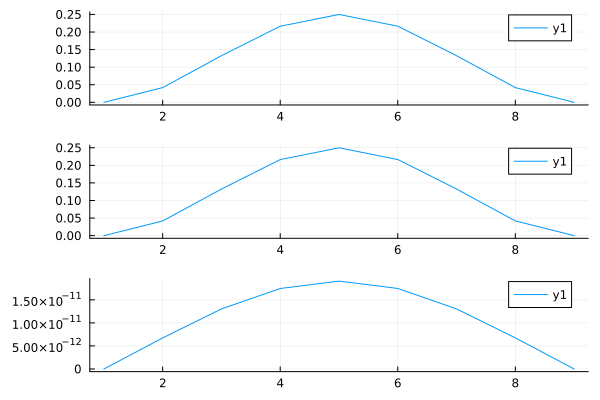

In [89]:
# first order method 
nels  = (8,)        # number of elements in each spatial direction
left  = Vec((0.,))   # start point for geometry: lower-left point of the square 
right = Vec((1.,))   # end point for geometry: upper-right point of the square
grid = generate_grid(Line,nels,left,right)

dim = 1
ip = Lagrange{dim, RefCube, 1}()
qr = QuadratureRule{dim, RefCube}(4)
cellvalues = CellScalarValues(qr, ip);

dh = DofHandler(grid)
add!(dh, :u, 1)
close!(dh);

K = create_sparsity_pattern(dh)

ch = ConstraintHandler(dh)

∂Ω = union(
    getfaceset(grid, "left"),
    getfaceset(grid, "right")
)

dbc = Dirichlet(:u, ∂Ω, (x, t) -> 0)
add!(ch, dbc)
close!(ch)

K, f = assemble_global(cellvalues, K, dh);

apply!(K, f, ch)
u = K \ f;

# evaluate analytical solution 
u_anal(x::Vec) = -x[1]*(x[1]-1)*sin(pi*x[1]);

u_anal(node::Node) = u_anal(node.x);

# initialize vector 
u_appl_analytical = zeros(ndofs(dh));

# Use the function u_anal(x::Vec) to get the dofs for the analytical function
apply_analytical!(u_appl_analytical, dh, :u, u_anal); 

# But we can use reshape_to_nodes to get the nodal values
u_appl_analytical_at_nodes = reshape_to_nodes(dh, u_appl_analytical, :u); 

p1 = plot(u)
p2 = plot(u_appl_analytical_at_nodes[1,:])
p3 = plot(abs.(u-u_appl_analytical_at_nodes[1,:]))
plot(p1,p2,p3, layout = (3,1))
# plot(p3)

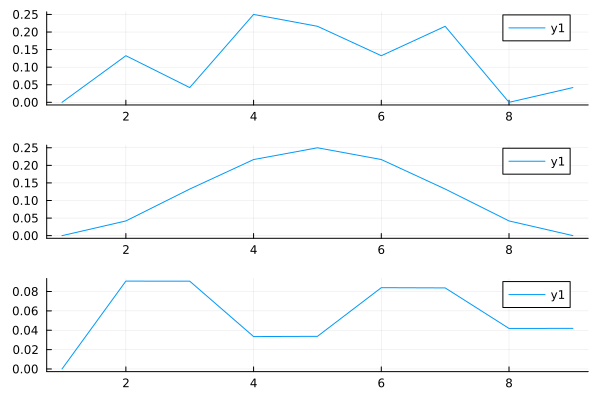

In [90]:
# second order method 
nels  = (4,)        # number of elements in each spatial direction
left  = Vec((0.,))   # start point for geometry: lower-left point of the square 
right = Vec((1.,))   # end point for geometry: upper-right point of the square
grid = generate_grid(QuadraticLine,nels,left,right)

dim = 1
ip = Lagrange{dim, RefCube, 2}()
qr = QuadratureRule{dim, RefCube}(4)
cellvalues = CellScalarValues(qr, ip);

dh = DofHandler(grid)
add!(dh, :u, 1)
close!(dh);

K = create_sparsity_pattern(dh)

ch = ConstraintHandler(dh)

∂Ω = union(
    getfaceset(grid, "left"),
    getfaceset(grid, "right")
)

dbc = Dirichlet(:u, ∂Ω, (x, t) -> 0)
add!(ch, dbc)
close!(ch)

K, f = assemble_global(cellvalues, K, dh);

apply!(K, f, ch)
u = K \ f;

# evaluate analytical solution 
u_anal(x::Vec) = -x[1]*(x[1]-1)*sin(pi*x[1]);

u_anal(node::Node) = u_anal(node.x);

# initialize vector 
u_appl_analytical = zeros(ndofs(dh));

# Use the function u_anal(x::Vec) to get the dofs for the analytical function
apply_analytical!(u_appl_analytical, dh, :u, u_anal); 

# But we can use reshape_to_nodes to get the nodal values
u_appl_analytical_at_nodes = reshape_to_nodes(dh, u_appl_analytical, :u); 

p1 = plot(u)
p2 = plot(u_appl_analytical_at_nodes[1,:])
p3 = plot(abs.(u-u_appl_analytical_at_nodes[1,:]))
plot(p1,p2,p3, layout = (3,1))
# plot(p3)

## Section 6: Solving the 2D Poisson Equation 

In [7]:
# define spatially varying diffusion coefficient 
function my_diff_coeff(x)
    xbound = abs(x[1])<0.3
    ybound = abs(x[2])<0.1 
    inPlate = xbound*ybound
    inAir   = 1-inPlate
    return 1 # 4*pi*1e-6*(inAir+1/100*inPlate) 
end 

# define spatially varying source functin 
function my_source(x)
    return 2*pi^2*sin(pi*x[1])*sin(pi*x[2]) 
end 

# Ke: added spatially varying diffusion coefficient 
# fe: forces zero source term 
function assemble_element!(Ke::Matrix, fe::Vector, cellvalues::CellScalarValues, mycoords)
    n_basefuncs = getnbasefunctions(cellvalues)
    # Reset to 0
    fill!(Ke, 0)
    fill!(fe, 0)
    # Loop over quadrature points
    for q_point in 1:getnquadpoints(cellvalues)
        # Get the quadrature weight
        dΩ = getdetJdV(cellvalues, q_point)
        # ADDED: Get coord of quadrature point
        coords_qp = spatial_coordinate(cellvalues, q_point, mycoords)
        # ADDED: Evaluate spatially dependent diffusion coefficient in quad point 
        val_diff_coeff = my_diff_coeff(coords_qp)
        # ADDED: Evaluate spatially dependent source term in quad point 
        val_source = my_source(coords_qp)        
        # Loop over test shape functions
        for i in 1:n_basefuncs
            δu  = shape_value(cellvalues, q_point, i)
            ∇δu = shape_gradient(cellvalues, q_point, i)
            # Add contribution to fe
            fe[i] += val_source * δu * dΩ
            # Loop over trial shape functions
            for j in 1:n_basefuncs
                ∇u = shape_gradient(cellvalues, q_point, j)
                # MODIFIED: Add contribution to Ke
                Ke[i, j] += val_diff_coeff * (∇δu ⋅ ∇u) * dΩ
            end
        end
    end
    return Ke, fe
end

assemble_element! (generic function with 1 method)

In [8]:
function assemble_global(cellvalues::CellScalarValues, K::SparseMatrixCSC, dh::DofHandler)
    # Allocate the element stiffness matrix and element force vector
    n_basefuncs = getnbasefunctions(cellvalues)
    Ke = zeros(n_basefuncs, n_basefuncs)
    fe = zeros(n_basefuncs)
    # Allocate global force vector f
    f = zeros(ndofs(dh))
    # Create an assembler
    assembler = start_assemble(K, f)
    # Loop over all cels
    for cell in CellIterator(dh)
        # Added: Get coordinates from current cell 
        coords = getcoordinates(cell)
        # Reinitialize cellvalues for this cell
        reinit!(cellvalues, cell)
        # Modified - Compute element contribution
        assemble_element!(Ke, fe, cellvalues, coords)
        # Assemble Ke and fe into K and f
        assemble!(assembler, celldofs(cell), Ke, fe)
    end
    return K, f
end

assemble_global (generic function with 1 method)

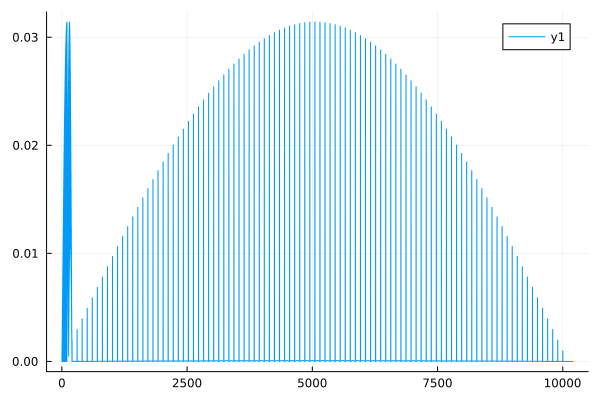

In [26]:
# first order method 
nelem = 100 
nels  = (nelem, nelem) # number of elements in each spatial direction
left  = Vec((0., 0.))    # start point for geometry 
right = Vec((1.0, 1.0,)) # end point for geometry
grid = generate_grid(Quadrilateral,nels,left,right);

dim = 2
ip = Lagrange{dim, RefCube, 1}()
qr = QuadratureRule{dim, RefCube}(4)
cellvalues = CellScalarValues(qr, ip);

dh = DofHandler(grid)
add!(dh, :u, 1)
close!(dh);

K = create_sparsity_pattern(dh)

ch = ConstraintHandler(dh)

∂Ω = union(
    getfaceset(grid, "left"),
    getfaceset(grid, "right"),
    getfaceset(grid, "top"),
    getfaceset(grid, "bottom"),
)

dbc = Dirichlet(:u, ∂Ω, (x, t) -> 0)
add!(ch, dbc)
close!(ch)

K, f = assemble_global(cellvalues, K, dh);

apply!(K, f, ch)
u = K \ f;

# evaluate analytical solution 
u_anal(node) = sin(pi*node.x[1])*sin(pi*node.x[2]) 
u_anal_vec = u_anal.(grid.nodes); 

plot(abs.(u-u_anal_vec))

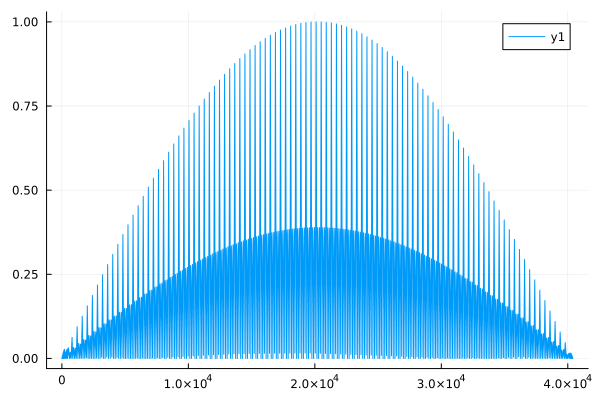

In [28]:
# second order method 
nelem = 100 
nels  = (nelem, nelem) # number of elements in each spatial direction
left  = Vec((0., 0.))    # start point for geometry 
right = Vec((1.0, 1.0,)) # end point for geometry
grid = generate_grid(QuadraticQuadrilateral,nels,left,right);

dim = 2
ip = Lagrange{dim, RefCube, 2}()
qr = QuadratureRule{dim, RefCube}(4)
cellvalues = CellScalarValues(qr, ip);

dh = DofHandler(grid)
add!(dh, :u, 1)
close!(dh);

K = create_sparsity_pattern(dh)

ch = ConstraintHandler(dh)

∂Ω = union(
    getfaceset(grid, "left"),
    getfaceset(grid, "right"),
    getfaceset(grid, "top"),
    getfaceset(grid, "bottom"),
)

dbc = Dirichlet(:u, ∂Ω, (x, t) -> 0)
add!(ch, dbc)
close!(ch)

K, f = assemble_global(cellvalues, K, dh);

apply!(K, f, ch)
u = K \ f;

# evaluate analytical solution 
u_anal(node) = sin(pi*node.x[1])*sin(pi*node.x[2]) 
u_anal_vec = u_anal.(grid.nodes); 

plot(abs.(u-u_anal_vec))

In [14]:
vtk_grid("computed_u", dh) do vtk
    vtk_point_data(vtk, dh, u)
end

1-element Vector{String}:
 "computed_u.vtu"

In [15]:
# evaluate analytical solution 
u_anal(node) = sin(pi*node.x[1])*sin(pi*node.x[2]) 
u_anal_vec = u_anal.(grid.nodes); 

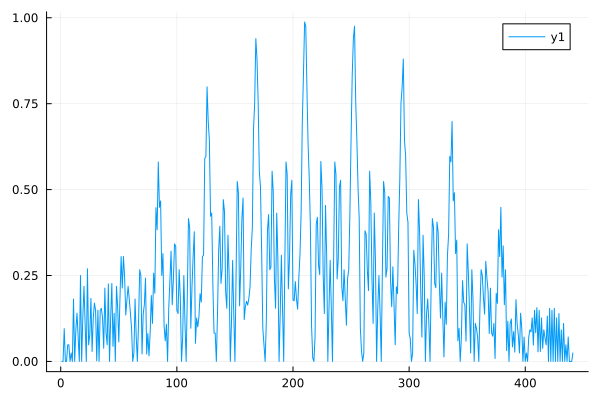

In [16]:
plot(abs.(u-u_anal_vec)) 

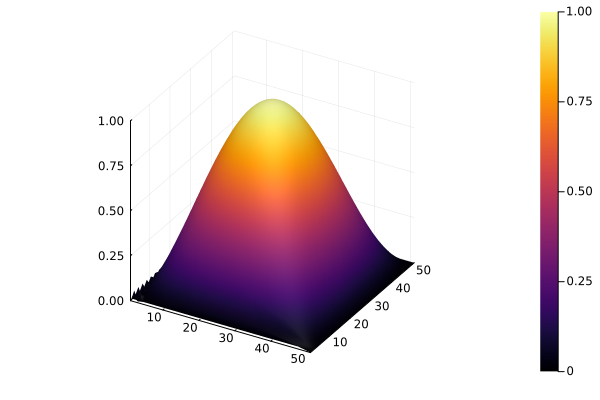

In [98]:
umat = reshape(u,51,51);
surface(umat)

In [99]:
grid.nodes

2601-element Vector{Node{2, Float64}}:
 Node{2, Float64}([0.0, 0.0])
 Node{2, Float64}([0.02, 0.0])
 Node{2, Float64}([0.04, 0.0])
 Node{2, Float64}([0.06, 0.0])
 Node{2, Float64}([0.08, 0.0])
 Node{2, Float64}([0.1, 0.0])
 Node{2, Float64}([0.12, 0.0])
 Node{2, Float64}([0.14, 0.0])
 Node{2, Float64}([0.16, 0.0])
 Node{2, Float64}([0.18, 0.0])
 Node{2, Float64}([0.2, 0.0])
 Node{2, Float64}([0.22, 0.0])
 Node{2, Float64}([0.24, 0.0])
 ⋮
 Node{2, Float64}([0.78, 1.0])
 Node{2, Float64}([0.8, 1.0])
 Node{2, Float64}([0.82, 1.0])
 Node{2, Float64}([0.84, 1.0])
 Node{2, Float64}([0.86, 1.0])
 Node{2, Float64}([0.88, 1.0])
 Node{2, Float64}([0.9, 1.0])
 Node{2, Float64}([0.92, 1.0])
 Node{2, Float64}([0.94, 1.0])
 Node{2, Float64}([0.96, 1.0])
 Node{2, Float64}([0.98, 1.0])
 Node{2, Float64}([1.0, 1.0])

## Section 7: Computing Fluxes

In [ ]:
function my_get_coords(dh::DofHandler)
    # Loop over all cels
    for (cellcount, cell) in enumerate(CellIterator(dh))
        coords = getcoordinates(cell)
        display(coords)
        reinit!(cellvalues, cell)
        for q_point in 1:getnquadpoints(cellvalues)
            coords_qp = spatial_coordinate(cellvalues, q_point, coords)
            # display(my_diff_coeff(coords_qp)) 
        end
    end
    return 0
end

In [ ]:
# define spatially varying diffusion coefficient 
function my_diff_coeff(coord_qp)
    xbound = abs(coord_qp[1])<0.3
    ybound = abs(coord_qp[2])<0.2 
    inPlate = xbound*ybound
    inAir   = 1-inPlate
    return 4*pi*1e-6*(inAir+1/100*inPlate) 
end 

In [ ]:
function compute_hfield(cellvalues::CellScalarValues{dim,T}, dh::DofHandler, a) where {dim,T}

    n = getnbasefunctions(cellvalues)
    cell_dofs = zeros(Int, n)
    nqp = getnquadpoints(cellvalues)

    # Allocate storage for the fluxes to store
    q = [Vec{2,T}[] for _ in 1:getncells(dh.grid)]

    for (cell_num, cell) in enumerate(CellIterator(dh))
        q_cell = q[cell_num]
        celldofs!(cell_dofs, dh, cell_num)
        aᵉ = a[cell_dofs]
        reinit!(cellvalues, cell)

        for q_point in 1:nqp
            q_qp = - function_gradient(cellvalues, q_point, aᵉ)
            push!(q_cell, q_qp)
        end
    end
    return q
end

function compute_bfield(cellvalues::CellScalarValues{dim,T}, dh::DofHandler, a) where {dim,T}

    n = getnbasefunctions(cellvalues)
    cell_dofs = zeros(Int, n)
    nqp = getnquadpoints(cellvalues)

    # Allocate storage for the fluxes to store
    q = [Vec{2,T}[] for _ in 1:getncells(dh.grid)]

    for (cell_num, cell) in enumerate(CellIterator(dh))
        q_cell = q[cell_num]
        celldofs!(cell_dofs, dh, cell_num)
        aᵉ = a[cell_dofs]
        reinit!(cellvalues, cell)
        coords = getcoordinates(cell)
        
        for q_point in 1:nqp
            coords_qp = spatial_coordinate(cellvalues, q_point, coords)
            val_diff_coeff = my_diff_coeff(coords_qp)
            q_qp = - val_diff_coeff*function_gradient(cellvalues, q_point, aᵉ)
            push!(q_cell, q_qp)
        end
    end
    return q
end

In [ ]:
h_gp = compute_hfield(cellvalues, dh, u);
b_gp = compute_bfield(cellvalues, dh, u);
#q_gp

In [ ]:
?L2Projector

In [ ]:
projector = L2Projector(ip, grid);
#projector 

In [ ]:
h_projected = project(projector, h_gp, qr; project_to_nodes=false);
b_projected = project(projector, b_gp, qr; project_to_nodes=false);
# q_projected

## Section 8: Exporting to VTK 

In [ ]:
#?vtk_point_data

In [ ]:
vtk_grid("2d_uniform_magn_plate", dh) do vtk
    vtk_point_data(vtk, dh, u, "Vm")
    vtk_point_data(vtk, projector, h_projected, "H")
    vtk_point_data(vtk, projector, b_projected, "B")
end